Ячейки следует запускать по очереди.

Ссылка на этот блокнот: https://colab.research.google.com/drive/1i6RG2G6KQMOigzthjIoDRmwZJtANE2aG?usp=sharing

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
'''
Разработка данного решения осуществлялась в Google Colaboratory. Необходимые файлы
хранились на google-диске. Для воспроизведения данного решения необходимо убедиться 
в существовании следующих директорий: 
'''

In [ ]:
os.makedirs('/content/drive/MyDrive/Documents/FLOORS/WALL/Results/U_Net_1/PREDICT') 
os.makedirs('/content/drive/MyDrive/Documents/FLOORS/WINDOW/Results/U_Net_1')
os.makedirs('/content/drive/MyDrive/Documents/FLOORS/submit_1_2')
os.makedirs('/content/drive/MyDrive/Documents/FLOORS/DOORS')

In [ ]:
'''
Архивы train_dataset_train.zip и test_dataset_test.zip необходимо поместить 
в директорию /content/drive/MyDrive/Documents/FLOORS
Затем нужно создать следующую сиcтему:
'''

In [ ]:
os.makedirs('/content/drive/My Drive/Documents/FLOORS/train_dataset_train/object_detection_1/images/train')
os.makedirs('/content/drive/My Drive/Documents/FLOORS/train_dataset_train/object_detection_1/labels/train')

os.makedirs('/content/drive/My Drive/Documents/FLOORS/train_dataset_train/object_detection_1/images/val')
os.makedirs('/content/drive/My Drive/Documents/FLOORS/train_dataset_train/object_detection_1/labels/val')

os.makedirs('/content/drive/My Drive/Documents/FLOORS/train_dataset_train/object_detection_1/images/test')
os.makedirs('/content/drive/My Drive/Documents/FLOORS/train_dataset_train/object_detection_1/labels/test')

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install segmentation-models
clear_output()

In [ ]:
from sklearn.utils import shuffle
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import plot_model, to_categorical
from keras.models import Model, load_model 
from keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from keras.optimizers import Adam
from keras.utils import Sequence
import multiprocessing
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore
from segmentation_models import get_preprocessing
import segmentation_models as sm
import seaborn as sns

import pandas as pd
import json
import cv2 
import tensorflow as tf
import keras
import base64
import torch

Segmentation Models: using `keras` framework.


In [ ]:
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
torch.manual_seed(0)

In [ ]:
!unzip -q '/content/drive/MyDrive/Documents/FLOORS/train_dataset_train.zip' -d '/content/drive/My Drive/Documents/FLOORS/train_dataset_train'

In [ ]:
!unzip -q '/content/drive/MyDrive/Documents/FLOORS/test_dataset_test.zip' -d '/content/drive/MyDrive/Documents/FLOORS/test_dataset_test'

In [ ]:
# Путь к данным для обучения
PATH = '/content/drive/MyDrive/Documents/FLOORS/train_dataset_train'

# Путь к данным для тестирования на платформе
PATH_TEST = '/content/drive/MyDrive/Documents/FLOORS/test_dataset_test'

# Путь к директории, куда будем записывать результаты тестового распознавания
PATH_SUBMIT = '/content/drive/MyDrive/Documents/FLOORS/submit_1_2'

WALL_DIR = 'train_wall'
WINDOW_DIR = 'train_window'
DOOR_DIR = 'object_detection'
DOOR_PROCESSED_DIR = 'object_detection_1'

PATH_WALL = os.path.join(PATH, WALL_DIR)
PATH_WINDOW = os.path.join(PATH, WINDOW_DIR)

IMAGE_DIR = 'image'
MASK_DIR = 'mask'

SIZE = (256, 256)

 # Размер данных, подаваемых в нейросеть для сегментации стен и окон одновременно
INPUT_SHAPE_WALL = (SIZE[1], SIZE[0], 1)  

# Размер данных, подаваемых в нейросеть для сегментации только окон
INPUT_SHAPE_WINDOW = (SIZE[1], SIZE[0], 2)  

# Количество классов для каждого отдельной нейросети
N_CLASSES = 1

# Название модели для сегментации стен и путь к ней
MODEL_NAME_WALL = 'U_Net_1' 
PATH_RESULTS_WALL = '/content/drive/MyDrive/Documents/FLOORS/WALL/Results'
PATH_MODEL_WALL = os.path.join(PATH_RESULTS_WALL, MODEL_NAME_WALL)
PATH_MODEL_WALL_PREDICT = os.path.join(PATH_RESULTS_WALL, MODEL_NAME_WALL, 'PREDICT')

# Название модели для сегментации окон и путь к ней
MODEL_NAME_WINDOW = 'U_Net_1' 
PATH_RESULTS_WINDOW = '/content/drive/MyDrive/Documents/FLOORS/WINDOW/Results'
PATH_MODEL_WINDOW = os.path.join(PATH_RESULTS_WINDOW, MODEL_NAME_WINDOW)


# Имена файлов, в которых будет сохранены обученные модели: лучшая и последняя
MODEL_FILENAME_WALL =  f'{MODEL_NAME_WALL}.h5' 
MODEL_FILENAME_WALL_LAST = f'{MODEL_NAME_WALL}_last.h5' 

MODEL_FILENAME_WINDOW =  f'{MODEL_NAME_WINDOW}.h5' 
MODEL_FILENAME_WINDOW_LAST = f'{MODEL_NAME_WINDOW}_last.h5' 


N_VAL = 256
N_TEST = 256


# Цвета для выделения классов на демонстрации результатов распознавания
COLOR_WALL = np.array([255, 255, 0], dtype = np.uint8)   # Сначала использовался желтый, потом я его заменила на красный
COLOR_WALL = np.array([255, 0, 0], dtype = np.uint8)
COLOR_WINDOW = np.array([0, 255, 0], dtype = np.uint8)
COLOR_DOOR = np.array([0, 0, 255], dtype = np.uint8)

COLOR_RATIO = 0.5

# Директории для обучения модели по обнаружению дверей
IMAGES_DIR = 'images'
LABELS_DIR = 'labels'

TRAIN_DIR = 'train'
VAL_DIR = 'val'
TEST_DIR = 'test'

PATH_YOLO_MODEL = '/content/drive/MyDrive/Documents/FLOORS/DOORS/yolov5/runs/train/yolov5x_results/weights/best.pt'

In [ ]:
def getData(path):
  image_files = sorted(os.listdir(os.path.join(path, IMAGE_DIR)))
  mask_files = sorted(os.listdir(os.path.join(path, MASK_DIR)))

  
  for i in range(len(image_files)):
    image_files[i] = os.path.join(path, IMAGE_DIR, image_files[i])
    mask_files[i] = os.path.join(path, MASK_DIR, mask_files[i])

  return image_files, mask_files

In [ ]:
# Предобработка изображений - в данным случае это нормализация
def normalization(x):
  return x/255.

preprocess_input = normalization

# Сегментация "стены + окна"

In [ ]:
image_files_wall, mask_files_wall = getData(PATH_WALL)

In [ ]:
N_TOTAL = len(image_files_wall)
N_TRAIN = N_TOTAL - N_VAL - N_TEST

image_files_wall_train = image_files_wall[:N_TRAIN]
mask_files_wall_train = mask_files_wall[:N_TRAIN]

image_files_wall_val = image_files_wall[N_TRAIN:N_TRAIN+N_VAL]
mask_files_wall_val = mask_files_wall[N_TRAIN:N_TRAIN+N_VAL]

image_files_wall_test = image_files_wall[N_TRAIN+N_VAL:]
mask_files_wall_test = mask_files_wall[N_TRAIN+N_VAL:]

print(f'Количество обучающий примеров: фото {len(image_files_wall_train)}, маски {len(mask_files_wall_train)}.')
print(f'Количество проверочных примеров: фото {len(image_files_wall_val)}, маски {len(mask_files_wall_val)}.')
print(f'Количество тестовых примеров: фото {len(image_files_wall_test)}, маски {len(mask_files_wall_test)}.')

image_files_wall_train = np.array(image_files_wall_train)
mask_files_wall_train = np.array(mask_files_wall_train)

image_files_wall_val = np.array(image_files_wall_val)
mask_files_wall_val = np.array(mask_files_wall_val)

image_files_wall_test = np.array(image_files_wall_test)
mask_files_wall_test = np.array(mask_files_wall_test)


Количество обучающий примеров: фото 2988, маски 2988.
Количество проверочных примеров: фото 256, маски 256.
Количество тестовых примеров: фото 256, маски 256.


In [ ]:

np.save(os.path.join(PATH_MODEL_WALL, 'loss.npy'), np.array([]))
np.save(os.path.join(PATH_MODEL_WALL, 'val_loss.npy'), np.array([]))
np.save(os.path.join(PATH_MODEL_WALL, 'iou_score.npy'), np.array([]))
np.save(os.path.join(PATH_MODEL_WALL, 'val_iou_score.npy'), np.array([]))


## Генератор данных

In [ ]:
class DataGeneratorWall(Sequence):
  
  # Инициализация
  def __init__(self, image_dataset, mask_dataset, batch_size, shuffle, augmentation,
               preprocessing = None):
    
    self.image_dataset = image_dataset
    self.mask_dataset = mask_dataset
    self.batch_size = batch_size
    self.n_samples = len(image_dataset)
    self.shuffle = shuffle
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.on_epoch_end()
  
  # Количество батчей за одну эпоху
  def __len__(self):
    return self.n_samples // self.batch_size
  

  # Получение батча изображений
  def __getitem__(self, index):

      indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

      image_batch = self.image_dataset[indices]
      mask_batch = self.mask_dataset[indices]

      x, y = self.__data_generation(image_batch, mask_batch)

      return x, y

  
  # Перемешиваем выборку в самом начале обучения и в конце каждой эпохи
  def on_epoch_end(self):
      self.indices = np.arange(self.n_samples)
      if self.shuffle == True:
          
          state = len(np.load(os.path.join(PATH_MODEL_WALL, 'loss.npy')))
          np.random.seed(state)
          np.random.shuffle(self.indices)

  
  # Создаем сами данные - загружаем изображения из файлов
  # В качестве аугментации применяем случайное отображение по
  # горизонтали и вертикали 
  def __data_generation(self, image_batch, mask_batch):

    images = list()
    masks = list()

    for i in range(len(image_batch)):
      
      image = Image.open(image_batch[i]).resize(SIZE, resample = Image.NEAREST)
      mask = Image.open(mask_batch[i]).resize(SIZE, resample = Image.NEAREST)
      
      if self.augmentation:
        
        np.random.seed(i)
        random_numbers = np.random.randint(low = 0, high = 2, size = 2)
        
        if random_numbers[0]:
          
          image = image.transpose(Image.FLIP_LEFT_RIGHT)
          mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

        if random_numbers[1]:
          
          image = image.transpose(Image.FLIP_TOP_BOTTOM)
          mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

      image = np.array(image)[..., np.newaxis]
      mask = np.array(mask)[..., np.newaxis]
      
      images.append(image)
      masks.append(mask)

    images = np.array(images).astype(np.float32)
    masks = np.array(masks).astype(np.float32)
    
    if self.preprocessing:
      images = self.preprocessing(images)
      masks = self.preprocessing(masks)

    return images, masks

## Примеры обучающих данных

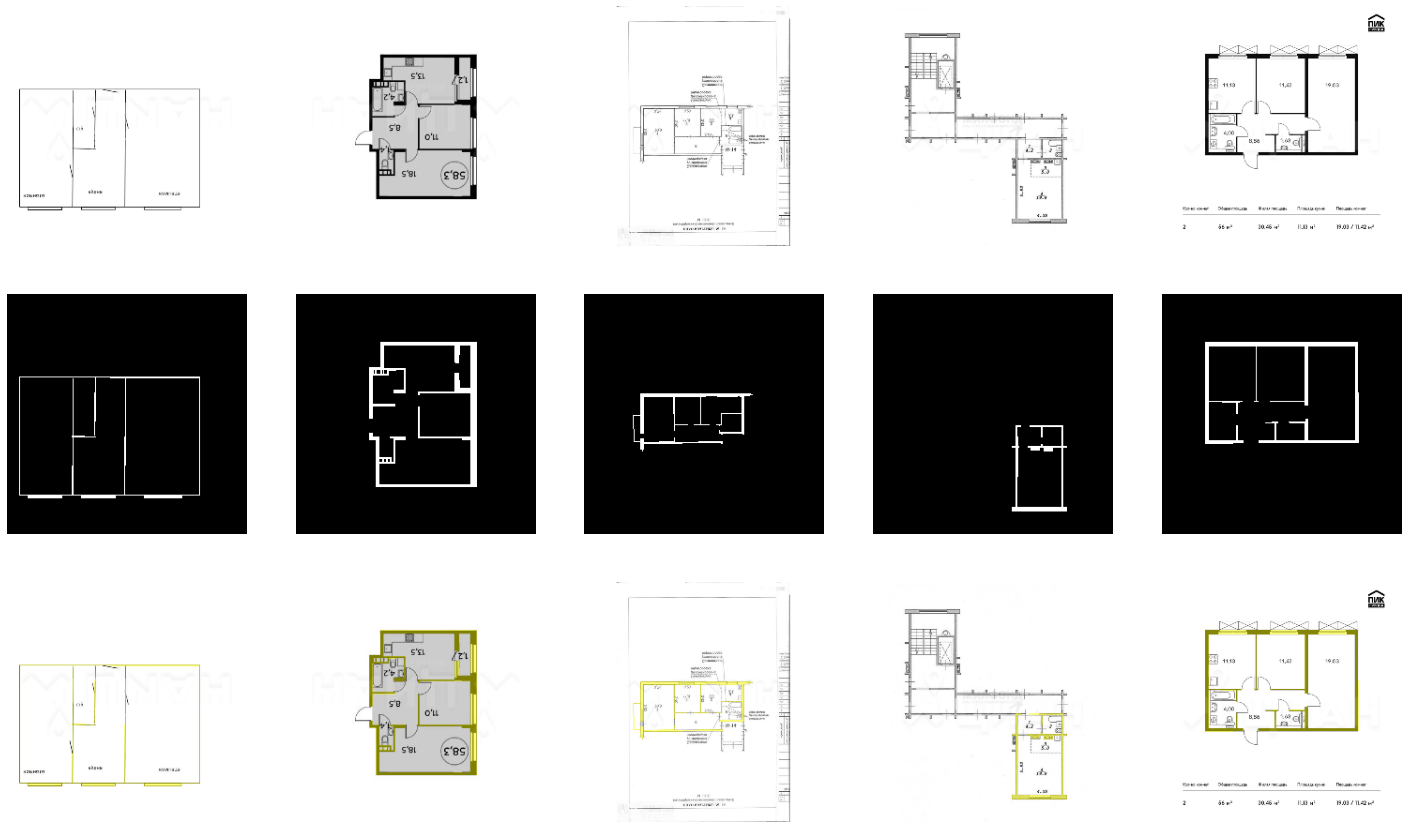

In [ ]:
# Примеры обучающих данных

n_samples = 5
generator = DataGeneratorWall(image_dataset = image_files_wall_train, 
                          mask_dataset = mask_files_wall_train, 
                          batch_size = n_samples, shuffle = True,
                          augmentation = True,
                          preprocessing = None)

x, y = generator.__getitem__(0)
plt.figure(figsize = (25, 15))


for i in range(n_samples):
  image = np.uint8(np.squeeze(x[i]))
  mask = np.uint8(np.squeeze(y[i]))

  plt.subplot(3, n_samples, i+1)
  plt.imshow(image, cmap = 'gray')
  plt.axis('off')

  plt.subplot(3, n_samples, n_samples+i+1)
  plt.imshow(mask, cmap = 'gray')
  plt.axis('off')

  color_image = np.repeat(np.array(image), 3).reshape(SIZE[0],SIZE[1], 3)

  masked_image = np.where(mask[...,None], COLOR_WALL, color_image)
  masked_image = cv2.addWeighted(color_image, COLOR_RATIO, masked_image, 1 - COLOR_RATIO, 0)

  plt.subplot(3, n_samples, 2*n_samples+i+1)
  plt.imshow(np.uint8(masked_image))
  plt.axis('off')


plt.show()

## Данные для обучения. Экземпляры генераторов.

In [ ]:
'''
 Эти генераторы будут использованы для обучения и оценки модели 
'''

BATCH_SIZE = 16

train_generator_wall = DataGeneratorWall(image_dataset = image_files_wall_train, 
                                          mask_dataset = mask_files_wall_train, 
                                          batch_size = BATCH_SIZE, shuffle = True, 
                                          augmentation = True, preprocessing = preprocess_input)

val_generator_wall = DataGeneratorWall(image_dataset = image_files_wall_val, 
                                        mask_dataset = mask_files_wall_val, 
                                        batch_size = BATCH_SIZE, shuffle = False,
                                        augmentation = False, preprocessing = preprocess_input)

test_generator_wall = DataGeneratorWall(image_dataset = image_files_wall_test, 
                                        mask_dataset = mask_files_wall_test, 
                                        batch_size = BATCH_SIZE, shuffle = False,
                                        augmentation = False, preprocessing = preprocess_input)

train_generator_eval_wall = DataGeneratorWall(image_dataset = image_files_wall_train, 
                                              mask_dataset = mask_files_wall_train, 
                                              batch_size = BATCH_SIZE, shuffle = False, 
                                              augmentation = False, preprocessing = preprocess_input)

'''
 Эти генераторы будут использованы в callback'е для демонстрации 
 промежуточных результатов обучения
'''

N_SAMPLES = 5

callback_generator_wall = DataGeneratorWall(image_dataset = image_files_wall_test, 
                                            mask_dataset = mask_files_wall_test, 
                                            batch_size = N_SAMPLES, shuffle = False,
                                            augmentation = False, preprocessing = None)

callback_preprocessing_generator_wall = DataGeneratorWall(image_dataset = image_files_wall_test, 
                                                          mask_dataset = mask_files_wall_test, 
                                                          batch_size = N_SAMPLES, shuffle = False,
                                                          augmentation = False, 
                                                          preprocessing = preprocess_input)

x_callback_wall, y_callback_true_wall = callback_generator_wall.__getitem__(0)
x_callback_preprocessed_wall, _ = callback_preprocessing_generator_wall.__getitem__(0)

## Callback

In [ ]:
def on_epoch_end_wall(epoch, logs):
  
  '''
  
    Функция используется внутри keras.callbacks.LambdaCallback.
    Ее действия:
    1) Вывод текущих значений ошибки и метрики.
    2) Сохранение значений ошибки и метрики на каждой эпохе.
    3) Вывод графиков, показывающих динамику обучения через каждые 5 эпох.
    4) Вывод примеров сегментации текущей лучшей моделью через каждые 5 эпох.
    

  '''


  print('\n')
  
  epochs_plot = 5

  if (epoch + 1) % epochs_plot == 0:
    
    sns.set_style('darkgrid')
    
    fig, axes = plt.subplots(1, 2, figsize = (20, 5))
    
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')

    axes[0].set_ylabel('Loss')
    axes[1].set_ylabel('Metrics')
  
    clear_output(wait = True)

    print('\n', 'Epoch: ', epoch + 1)

  for key in logs.keys():
    path = os.path.join(PATH_MODEL_WALL, f'{key}.npy') 
    
    if epoch != 0:
      values = np.append(np.load(path), logs[key])
      np.save(path, values)

      best_value = np.min(values) if 'loss' in key else np.max(values)
      if (epoch + 1) % epochs_plot == 0:
        
        column = int(not 'loss' in key)
        axes[column].plot(values, label = key)

    else:
      np.save(path, np.array([logs[key]]))
      best_value = logs[key]

    print(f'{key}: {round(logs[key], 4)}, best_{key}: {round(best_value, 4)}')
  
  if (epoch + 1) % epochs_plot == 0:
    
    axes[0].legend()
    axes[1].legend()

    plt.show()

    sns.set_style('white')
    
    print(end = '\n\n')

    model_best = load_model(os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL), 
                   custom_objects = {'dice_loss':  DiceLoss(),
                                     'iou_score': IOUScore()})
    
    y_callback_pred_wall = model_best.predict(x_callback_preprocessed_wall)
    
    y_callback_pred_wall[y_callback_pred_wall < 0.5] = 0
    y_callback_pred_wall[y_callback_pred_wall >= 0.5] = 1
    
    
    plt.figure(figsize = (25, 15))


    for i in range(N_SAMPLES):
      
      image = np.uint8(np.squeeze(x_callback_wall[i]))
      mask_true = np.squeeze(y_callback_true_wall[i])
      mask_pred = np.squeeze(y_callback_pred_wall[i])

      plt.subplot(3, N_SAMPLES, i+1)
      plt.imshow(image, cmap = 'gray')
      plt.axis('off')

      color_image = np.repeat(np.array(image), 3).reshape(SIZE[1],SIZE[0], 3)

      masked_pred_image = np.where(mask_pred[...,None], COLOR_WALL, color_image)
      masked_pred_image = cv2.addWeighted(color_image, COLOR_RATIO, masked_pred_image, 1 - COLOR_RATIO, 0)

      plt.subplot(3, N_SAMPLES, N_SAMPLES+i+1)
      plt.imshow(masked_pred_image, cmap = 'gray')
      plt.axis('off')

      masked_true_image = np.where(mask_true[...,None], COLOR_WALL, color_image)
      masked_true_image = cv2.addWeighted(color_image, COLOR_RATIO, masked_true_image, 1 - COLOR_RATIO, 0)

      plt.subplot(3, N_SAMPLES, 2*N_SAMPLES+i+1)
      plt.imshow(masked_true_image)
      plt.axis('off')


    plt.show()

callback_on_epoch_end_wall = LambdaCallback(on_epoch_end = on_epoch_end_wall)

## Нейросеть


In [ ]:
def U_Net_1(num_classes, input_shape, activation):
                   
    img_input = Input(input_shape)                                              
    
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)      
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)              
    x = BatchNormalization()(x)                                                
    block_1_out = Activation('relu')(x)                                         
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)          
    block_1_out_up_4 = MaxPooling2D()(block_1_out_mask)                         
    block_1_out_up_3 = MaxPooling2D()(block_1_out_up_4)                         
    block_1_out_up_2 = MaxPooling2D()(block_1_out_up_3)                         
    block_1_out_up_1 = MaxPooling2D()(block_1_out_up_2)                         

    
    x = MaxPooling2D()(block_1_out)                                             
    
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)             
    x = BatchNormalization()(x)                                                
    x = Activation('relu')(x)                                                   

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)            
    x = BatchNormalization()(x)                                                 
    block_2_out = Activation('relu')(x)                                        

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out)         
    
    x = MaxPooling2D()(block_2_out)                                             

    
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)             
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                  

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)             
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)             
    x = BatchNormalization()(x)                                                 
    block_3_out = Activation('relu')(x)                                         

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out)        
        
    x = MaxPooling2D()(block_3_out)                                             

     
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)             
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                  

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)             
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)             
    x = BatchNormalization()(x)                                                 
    block_4_out = Activation('relu')(x)                                         

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out)         
            
    x = MaxPooling2D()(block_4_out)                                             

    
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)             
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)             
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)             
    x = BatchNormalization()(x)                                                 
    block_5_out = Activation('relu')(x)                                                   

    block_5_out_mask = Conv2D(512, (1, 1), padding='same')(block_5_out)      
  
    x = MaxPooling2D()(block_5_out)

    
    x = Conv2D(512, (3, 3), padding='same', name='block6_conv1')(x)             
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(512, (3, 3), padding='same', name='block6_conv2')(x)             
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(512, (3, 3), padding='same', name='block6_conv3')(x)             
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                        

                                  
 
    
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)         
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = concatenate([x, block_5_out, block_5_out_mask, block_1_out_up_1])       
    x = Conv2D(512, (3, 3), padding='same')(x)                                  
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(512, (3, 3), padding='same')(x)                                  
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)         
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = concatenate([x, block_4_out, block_4_out_mask, block_1_out_up_2])       
    x = Conv2D(512, (3, 3), padding='same')(x)                                  
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(512, (3, 3), padding='same')(x)                                  
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)         
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = concatenate([x, block_3_out, block_3_out_mask, block_1_out_up_3])       
    x = Conv2D(256, (3, 3), padding='same')(x)                                  
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(256, (3, 3), padding='same')(x)                                  
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)         
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = concatenate([x, block_2_out, block_2_out_mask, block_1_out_up_4])       
    x = Conv2D(128, (3, 3), padding='same')(x)                                  
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(128, (3, 3), padding='same')(x)                                  
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)          
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = concatenate([x, block_1_out, block_1_out_mask])                         
    x = Conv2D(64, (3, 3), padding='same')(x)                                   
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(64, (3, 3), padding='same')(x)                                   
    x = BatchNormalization()(x)                                                 
    x = Activation('relu')(x)                                                   

    x = Conv2D(num_classes, (3, 3), activation=activation, padding='same')(x)    

    model = Model(img_input, x)                                                
        
    
    return model

## Обучение


### Сеанс №1

In [ ]:
model = U_Net_1(N_CLASSES, INPUT_SHAPE_WALL, activation='sigmoid')


 Epoch:  20
loss: 0.0636, best_loss: 0.0636
iou_score: 0.882, best_iou_score: 0.882
val_loss: 0.0753, best_val_loss: 0.0718
val_iou_score: 0.8606, best_val_iou_score: 0.8664


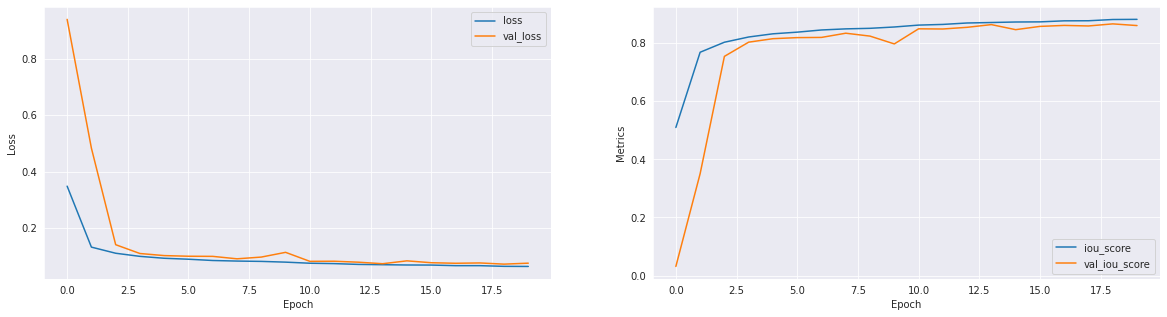



1/1 [==============================] - 1s 626ms/step


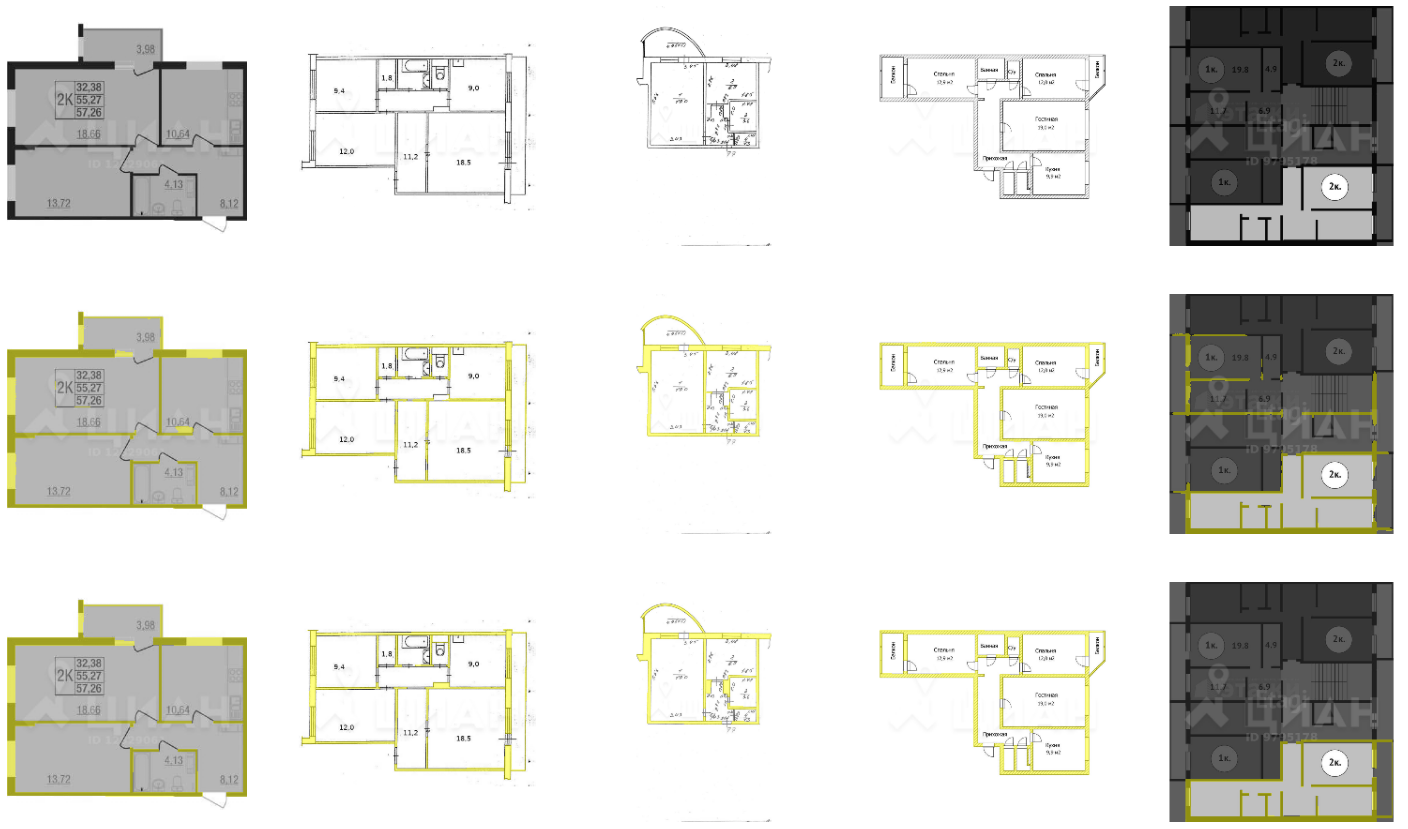


Epoch 20: val_iou_score did not improve from 0.86644

Epoch 20: saving model to /content/drive/MyDrive/Documents/FLOORS/WALL/Results/U_Net_1/U_Net_1_last.h5
186/186 [==============================] - 286s 2s/step - loss: 0.0636 - iou_score: 0.8820 - val_loss: 0.0753 - val_iou_score: 0.8606 - lr: 1.0000e-04


In [ ]:
dice_loss = DiceLoss()
iou_score = IOUScore()

model.compile(optimizer = Adam(learning_rate = 1e-4), loss = dice_loss, 
                metrics = iou_score)

checkpoint_callback_best = ModelCheckpoint(monitor = 'val_iou_score', 
                                          mode = 'max',
                                          filepath = os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL),
                                          save_weights_only = False,
                                          save_best_only = True,
                                          verbose = 1)


checkpoint_callback_last = ModelCheckpoint(filepath = os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL_LAST),
                                              save_weights_only = False,
                                              save_best_only = False,
                                              verbose = 1)

plateau_callback = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, verbose = 1,
                                     min_lr = 1e-10)                

callbacks = [callback_on_epoch_end_wall, checkpoint_callback_best, 
             checkpoint_callback_last, plateau_callback]

history = model.fit(train_generator_wall, validation_data = val_generator_wall,
                    epochs = 20, verbose = 1, 
                    use_multiprocessing = True,
                    workers = multiprocessing.cpu_count(),
                    callbacks = callbacks, 
                    initial_epoch = 0)

### Сеанс №2


 Epoch:  40
loss: 0.0524, best_loss: 0.0519
iou_score: 0.902, best_iou_score: 0.903
val_loss: 0.0636, best_val_loss: 0.0627
val_iou_score: 0.8808, best_val_iou_score: 0.8824


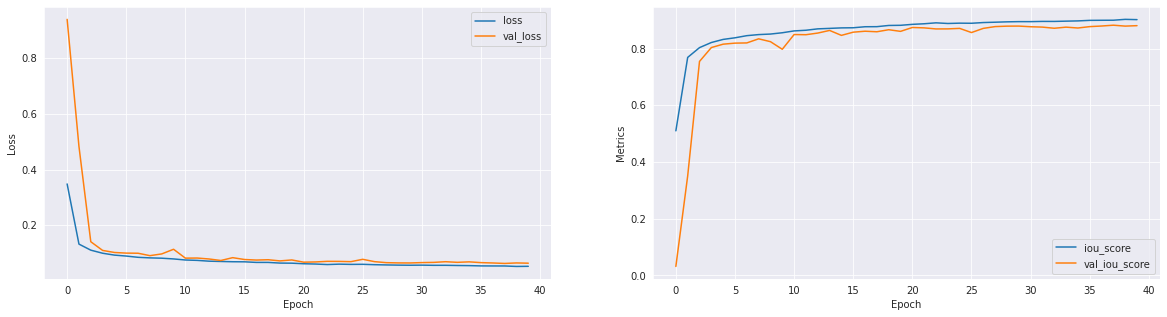



1/1 [==============================] - 1s 625ms/step


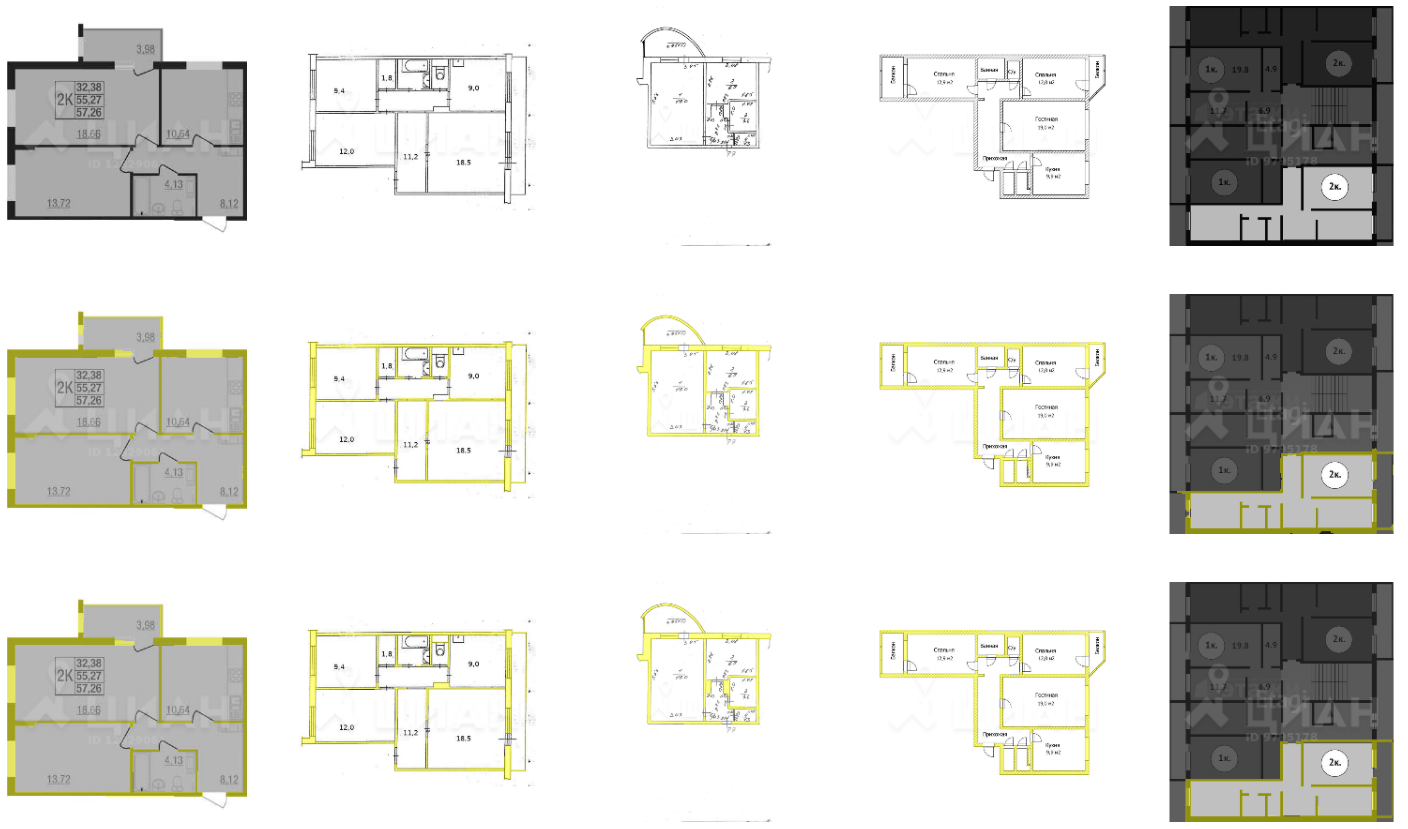


Epoch 40: val_iou_score did not improve from 0.88236

Epoch 40: saving model to /content/drive/MyDrive/Documents/FLOORS/WALL/Results/U_Net_1/U_Net_1_last.h5
186/186 [==============================] - 272s 1s/step - loss: 0.0524 - iou_score: 0.9020 - val_loss: 0.0636 - val_iou_score: 0.8808 - lr: 7.0000e-05
Epoch 41/100
186/186 [==============================] - ETA: 0s - loss: 0.0524 - iou_score: 0.9020

loss: 0.0524, best_loss: 0.0519
iou_score: 0.902, best_iou_score: 0.903
val_loss: 0.062, best_val_loss: 0.062
val_iou_score: 0.8835, best_val_iou_score: 0.8835

Epoch 41: val_iou_score improved from 0.88236 to 0.88350, saving model to /content/drive/MyDrive/Documents/FLOORS/WALL/Results/U_Net_1/U_Net_1.h5

Epoch 41: saving model to /content/drive/MyDrive/Documents/FLOORS/WALL/Results/U_Net_1/U_Net_1_last.h5
186/186 [==============================] - 231s 1s/step - loss: 0.0524 - iou_score: 0.9020 - val_loss: 0.0620 - val_iou_score: 0.8835 - lr: 7.0000e-05
Epoch 42/100
186/186 [=======

In [ ]:
model = load_model(os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL_LAST), 
                   custom_objects = {'dice_loss':  DiceLoss(),
                                     'iou_score': IOUScore()})

dice_loss = DiceLoss()
iou_score = IOUScore()

model.compile(optimizer = Adam(learning_rate = 0.7e-4), loss = dice_loss, 
                metrics = iou_score)

initial_value_threshold = max(np.load(os.path.join(PATH_MODEL_WALL, 'val_iou_score.npy')))

checkpoint_callback_best = ModelCheckpoint(monitor = 'val_iou_score', 
                                          mode = 'max',
                                          filepath = os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL),
                                          save_weights_only = False,
                                          save_best_only = True,
                                          verbose = 1,
                                          initial_value_threshold = initial_value_threshold)


checkpoint_callback_last = ModelCheckpoint(filepath = os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL_LAST),
                                              save_weights_only = False,
                                              save_best_only = False,
                                              verbose = 1)

plateau_callback = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, verbose = 1,
                                     min_lr = 1e-10)                

callbacks = [callback_on_epoch_end_wall, checkpoint_callback_best, 
             checkpoint_callback_last, plateau_callback]

initial_epoch = len(np.load(os.path.join(PATH_MODEL_WALL, 'loss.npy')))

history = model.fit(train_generator_wall, validation_data = val_generator_wall,
                    epochs = 42, verbose = 1, 
                    use_multiprocessing = True,
                    workers = multiprocessing.cpu_count(),
                    callbacks = callbacks, 
                    initial_epoch = initial_epoch)

### Сеанс №3


 Epoch:  100
loss: 0.0379, best_loss: 0.0376
iou_score: 0.9284, best_iou_score: 0.9288
val_loss: 0.0582, best_val_loss: 0.0575
val_iou_score: 0.8903, best_val_iou_score: 0.8916


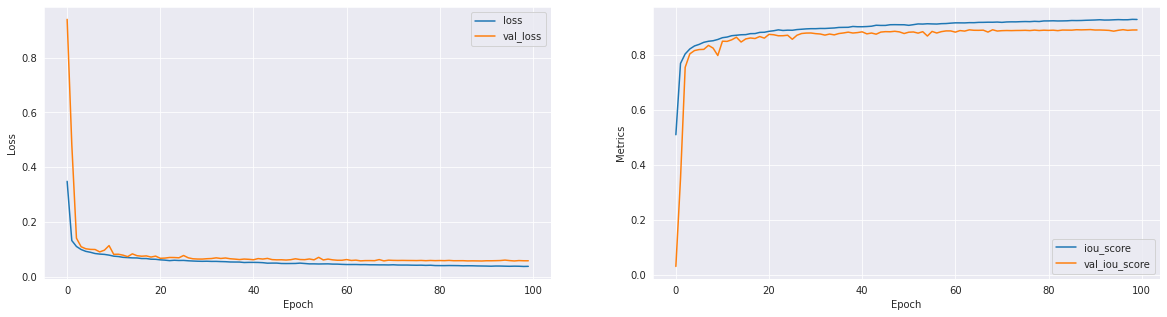



1/1 [==============================] - 1s 605ms/step


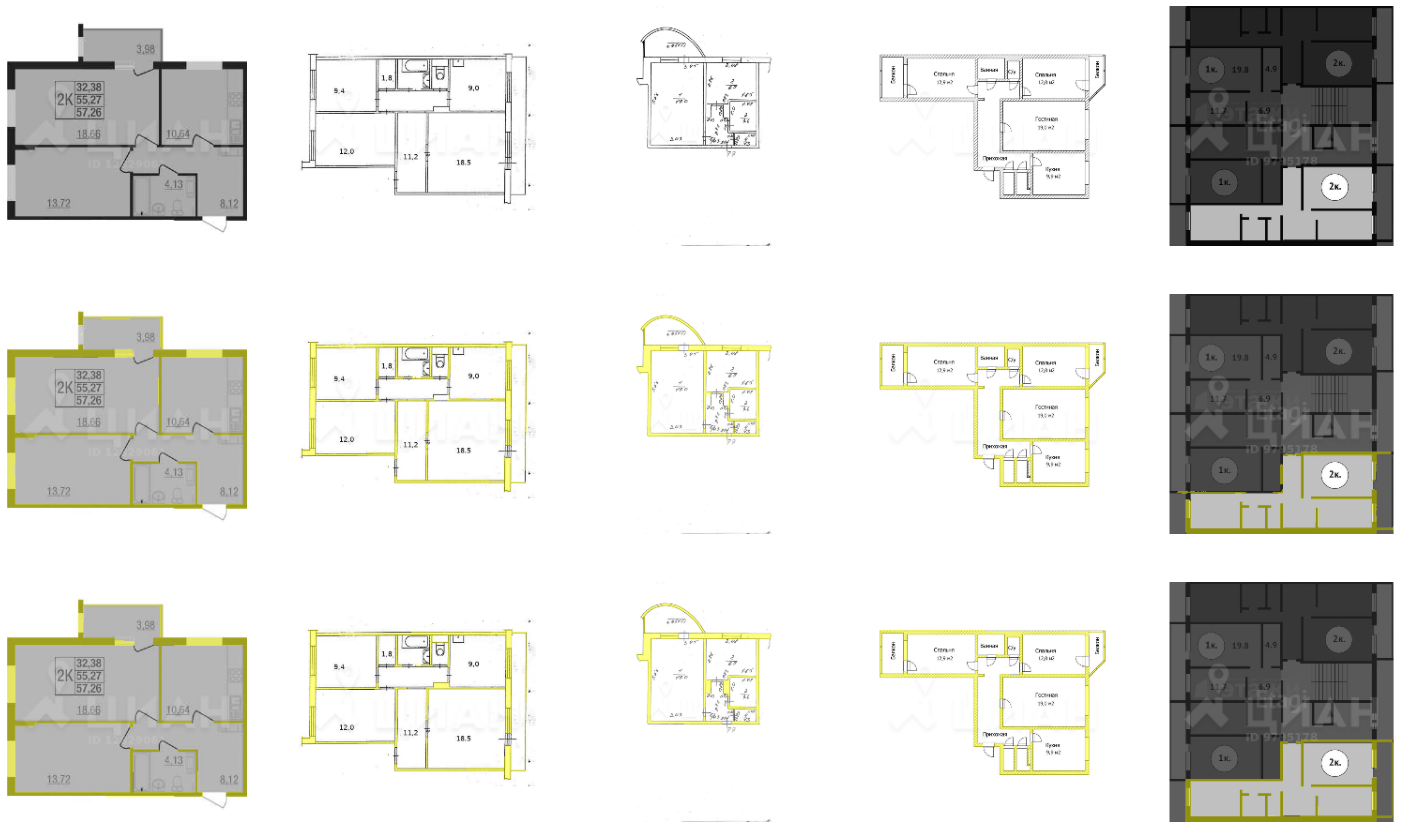


Epoch 100: val_iou_score did not improve from 0.89162

Epoch 100: saving model to /content/drive/MyDrive/Documents/FLOORS/WALL/Results/U_Net_1/U_Net_1_last.h5

Epoch 100: ReduceLROnPlateau reducing learning rate to 1.1764900045818648e-05.
186/186 [==============================] - 247s 1s/step - loss: 0.0379 - iou_score: 0.9284 - val_loss: 0.0582 - val_iou_score: 0.8903 - lr: 1.6807e-05


In [ ]:
model = load_model(os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL_LAST), 
                   custom_objects = {'dice_loss':  DiceLoss(),
                                     'iou_score': IOUScore()})

dice_loss = DiceLoss()
iou_score = IOUScore()

model.compile(optimizer = Adam(learning_rate = 0.49e-4), loss = dice_loss, 
                metrics = iou_score)

initial_value_threshold = max(np.load(os.path.join(PATH_MODEL_WALL, 'val_iou_score.npy')))

checkpoint_callback_best = ModelCheckpoint(monitor = 'val_iou_score', 
                                          mode = 'max',
                                          filepath = os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL),
                                          save_weights_only = False,
                                          save_best_only = True,
                                          verbose = 1,
                                          initial_value_threshold = initial_value_threshold)


checkpoint_callback_last = ModelCheckpoint(filepath = os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL_LAST),
                                              save_weights_only = False,
                                              save_best_only = False,
                                              verbose = 1)

plateau_callback = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, verbose = 1,
                                     min_lr = 1e-10)                

callbacks = [callback_on_epoch_end_wall, checkpoint_callback_best, 
             checkpoint_callback_last, plateau_callback]

initial_epoch = len(np.load(os.path.join(PATH_MODEL_WALL, 'loss.npy')))

history = model.fit(train_generator_wall, validation_data = val_generator_wall,
                    epochs = 100, verbose = 1, 
                    use_multiprocessing = True,
                    workers = multiprocessing.cpu_count(),
                    callbacks = callbacks, 
                    initial_epoch = initial_epoch)

# Сегментация окон

In [ ]:
image_files_window, mask_files_window = getData(PATH_WINDOW)

In [ ]:
# Предсказание карты сегментации стен

model_best = load_model(os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL), 
                custom_objects = {'dice_loss':  DiceLoss(),
                                  'iou_score': IOUScore()})

for filepath in image_files_window:

  image = Image.open(filepath).resize(SIZE, resample = Image.NEAREST)
  image = np.array(image)
  image = preprocess_input(image)
  
  image = image[np.newaxis, ..., np.newaxis]
  mask = model_best.predict(image)

  mask[mask < 0.5] = 0
  mask[mask >= 0.5] = 255
  mask = np.squeeze(mask)

  filename = os.path.split(filepath)[-1]

  mask_Image = Image.fromarray(np.uint8(mask))
  mask_Image.save(os.path.join(PATH_MODEL_WALL_PREDICT, filename))


In [ ]:
input_mask_files_window = sorted(os.listdir(PATH_MODEL_WALL_PREDICT))

for i in range(len(input_mask_files_window)):
  input_mask_files_window[i] = os.path.join(PATH_MODEL_WALL_PREDICT, input_mask_files_window[i])

In [ ]:
N_TOTAL = len(image_files_window)
N_TRAIN = N_TOTAL - N_VAL - N_TEST

image_files_window_train = image_files_window[:N_TRAIN]
mask_files_window_train = mask_files_window[:N_TRAIN]
input_mask_files_window_train = input_mask_files_window[:N_TRAIN]

image_files_window_val = image_files_window[N_TRAIN:N_TRAIN+N_VAL]
mask_files_window_val = mask_files_window[N_TRAIN:N_TRAIN+N_VAL]
input_mask_files_window_val = input_mask_files_window[N_TRAIN:N_TRAIN+N_VAL]

image_files_window_test = image_files_window[N_TRAIN+N_VAL:]
mask_files_window_test = mask_files_window[N_TRAIN+N_VAL:]
input_mask_files_window_test = input_mask_files_window[N_TRAIN+N_VAL:]

print(f'Количество обучающий примеров: фото {len(image_files_window_train)}, маски {len(mask_files_window_train)}.')
print(f'Количество проверочных примеров: фото {len(image_files_window_val)}, маски {len(mask_files_window_val)}.')
print(f'Количество тестовых примеров: фото {len(image_files_window_test)}, маски {len(mask_files_window_test)}.')

image_files_window_train = np.array(image_files_window_train)
mask_files_window_train = np.array(mask_files_window_train)
input_mask_files_window_train = np.array(input_mask_files_window_train)

image_files_window_val = np.array(image_files_window_val)
mask_files_window_val = np.array(mask_files_window_val)
input_mask_files_window_val = np.array(input_mask_files_window_val)

image_files_window_test = np.array(image_files_window_test)
mask_files_window_test = np.array(mask_files_window_test)
input_mask_files_window_test = np.array(input_mask_files_window_test)

Количество обучающий примеров: фото 2988, маски 2988.
Количество проверочных примеров: фото 256, маски 256.
Количество тестовых примеров: фото 256, маски 256.


In [ ]:

np.save(os.path.join(PATH_MODEL_WINDOW, 'loss.npy'), np.array([]))
np.save(os.path.join(PATH_MODEL_WINDOW, 'val_loss.npy'), np.array([]))
np.save(os.path.join(PATH_MODEL_WINDOW, 'iou_score.npy'), np.array([]))
np.save(os.path.join(PATH_MODEL_WINDOW, 'val_iou_score.npy'), np.array([]))


## Генератор данных

In [ ]:
class DataGeneratorWindow(Sequence):
  
  # Инициализация
  def __init__(self, image_dataset, mask_dataset, input_mask_dataset, batch_size, 
               shuffle, augmentation, preprocessing = None):
               
    
    self.image_dataset = image_dataset
    self.mask_dataset = mask_dataset
    self.input_mask_dataset = input_mask_dataset
    self.batch_size = batch_size
    self.n_samples = len(image_dataset)
    self.shuffle = shuffle
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.on_epoch_end()
  
  # Количество батчей за одну эпоху
  def __len__(self):
    return self.n_samples // self.batch_size
  

  # Получение батча изображений
  def __getitem__(self, index):

      indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

      image_batch = self.image_dataset[indices]
      mask_batch = self.mask_dataset[indices]
      input_mask_batch = self.input_mask_dataset[indices]
      
      x, y = self.__data_generation(image_batch, mask_batch, input_mask_batch)

      return x, y

  
  # Перемешиваем выборку в самом начале обучения и в конце каждой эпохи
  def on_epoch_end(self):
      self.indices = np.arange(self.n_samples)
      if self.shuffle == True:
          
          state = len(np.load(os.path.join(PATH_MODEL_WINDOW, 'loss.npy')))
          np.random.seed(state)
          np.random.shuffle(self.indices)

  
  # Создаем сами данные - загружаем изображения из файлов
  # В качестве аугментации применяем случайное отображение по
  # горизонтали и вертикали 
  def __data_generation(self, image_batch, mask_batch, input_mask_batch):

    images = list()
    masks = list()

    for i in range(len(image_batch)):
      
      image = Image.open(image_batch[i]).resize(SIZE, resample = Image.NEAREST)
      mask = Image.open(mask_batch[i]).resize(SIZE, resample = Image.NEAREST)
      input_mask = Image.open(input_mask_batch[i])

      if self.augmentation:
        
        np.random.seed(i)
        random_numbers = np.random.randint(low = 0, high = 2, size = 2)
        
        if random_numbers[0]:
          
          image = image.transpose(Image.FLIP_LEFT_RIGHT)
          mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
          input_mask = input_mask.transpose(Image.FLIP_LEFT_RIGHT)

        if random_numbers[1]:
          
          image = image.transpose(Image.FLIP_TOP_BOTTOM)
          mask = mask.transpose(Image.FLIP_TOP_BOTTOM)
          input_mask = input_mask.transpose(Image.FLIP_TOP_BOTTOM)

      image = np.array(image)[..., np.newaxis]     
      mask = np.array(mask)[..., np.newaxis]
      input_mask = np.array(input_mask)[..., np.newaxis]

      image = np.concatenate([image, input_mask], axis = -1)

      images.append(image)
      masks.append(mask)

    images = np.array(images).astype(np.float32)
    masks = np.array(masks).astype(np.float32)
    
    if self.preprocessing:
      images = self.preprocessing(images)
      masks = self.preprocessing(masks)

    return images, masks

## Примеры обучающих данных

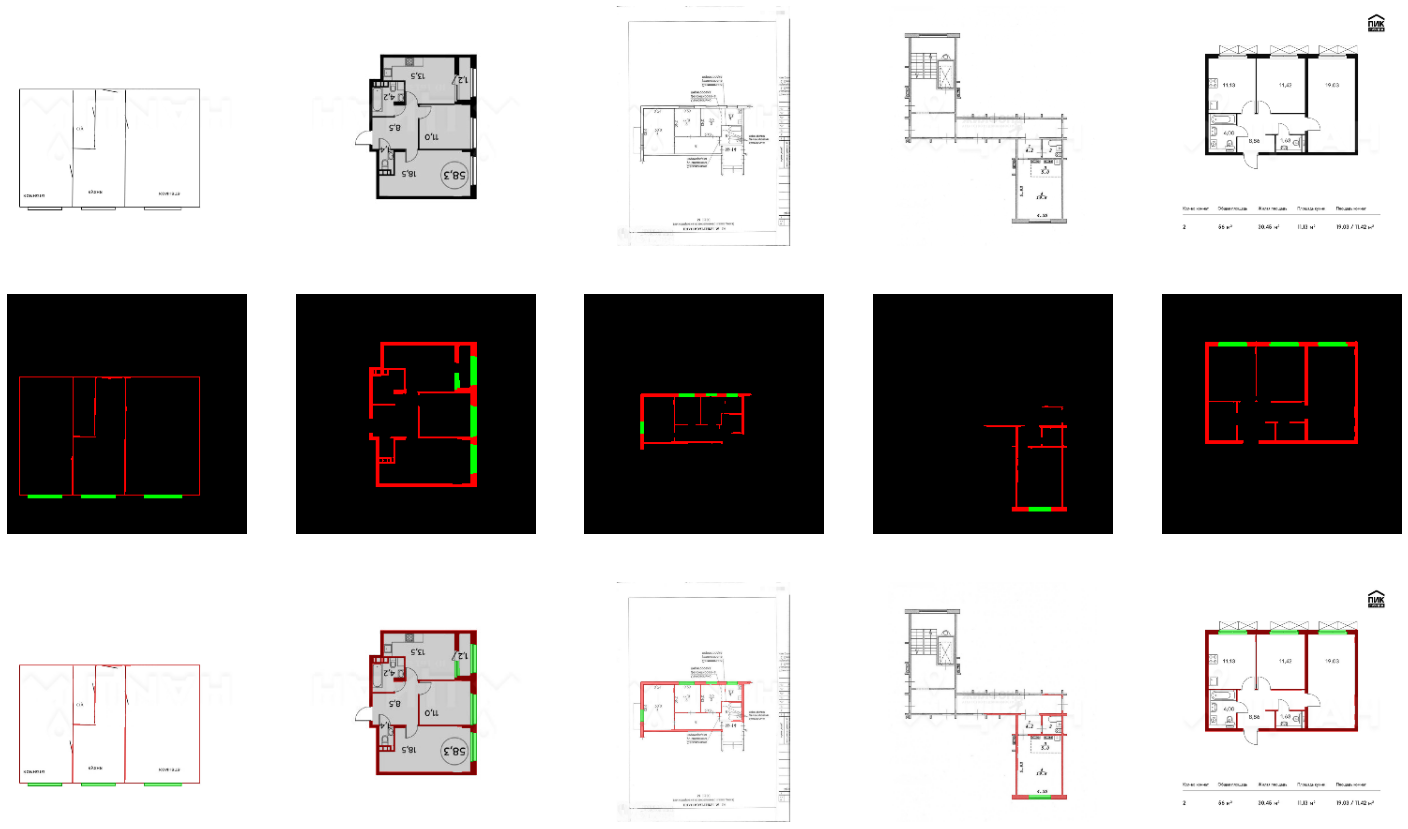

In [ ]:
# Примеры обучающих данных

n_samples = 5
generator = DataGeneratorWindow(image_dataset = image_files_window_train, 
                                mask_dataset = mask_files_window_train, 
                                input_mask_dataset = input_mask_files_window_train,
                                batch_size = n_samples, shuffle = True,
                                augmentation = True,
                                preprocessing = None)

x, y = generator.__getitem__(0)
plt.figure(figsize = (25, 15))

for i in range(n_samples):
  image = np.uint8(x[i][:, :, 0])
  input_mask = np.uint8(x[i][:, :, 1])
  mask = np.uint8(np.squeeze(y[i]))

  plt.subplot(3, n_samples, i+1)
  plt.imshow(image, cmap = 'gray')
  plt.axis('off')

  combined_mask = np.zeros((SIZE[1], SIZE[0], 3), dtype = np.uint8)
  combined_mask = np.where(input_mask[..., None], COLOR_WALL, combined_mask)
  combined_mask = np.where(mask[..., None], COLOR_WINDOW, combined_mask)


  plt.subplot(3, n_samples, n_samples+i+1)
  plt.imshow(combined_mask)
  plt.axis('off')

  color_image = np.repeat(np.array(image), 3).reshape(SIZE[1],SIZE[0], 3)

  masked_image = np.where(input_mask[...,None], COLOR_WALL, color_image)
  masked_image = np.where(mask[..., None], COLOR_WINDOW, masked_image)

  masked_image = cv2.addWeighted(color_image, COLOR_RATIO, masked_image, 1 - COLOR_RATIO, 0)

  plt.subplot(3, n_samples, 2*n_samples+i+1)
  plt.imshow(np.uint8(masked_image))
  plt.axis('off')


plt.show()

## Данные для обучения. Экземпляры генераторов.

In [ ]:
'''
 Эти генераторы будут использованы для обучения и оценки модели 
'''

BATCH_SIZE = 16

train_generator_window = DataGeneratorWindow(image_dataset = image_files_window_train, 
                                              mask_dataset = mask_files_window_train, 
                                              input_mask_dataset = input_mask_files_window_train,
                                              batch_size = BATCH_SIZE, shuffle = True, 
                                              augmentation = True, preprocessing = preprocess_input)

val_generator_window = DataGeneratorWindow(image_dataset = image_files_window_val, 
                                            mask_dataset = mask_files_window_val, 
                                            input_mask_dataset = input_mask_files_window_val,
                                            batch_size = BATCH_SIZE, shuffle = False,
                                            augmentation = False, preprocessing = preprocess_input)

test_generator_window = DataGeneratorWindow(image_dataset = image_files_window_test, 
                                            mask_dataset = mask_files_window_test, 
                                            input_mask_dataset = input_mask_files_window_test,
                                            batch_size = BATCH_SIZE, shuffle = False,
                                            augmentation = False, preprocessing = preprocess_input)

train_generator_eval_window = DataGeneratorWindow(image_dataset = image_files_window_train, 
                                                  mask_dataset = mask_files_window_train, 
                                                  input_mask_dataset = input_mask_files_window_train,
                                                  batch_size = BATCH_SIZE, shuffle = False, 
                                                  augmentation = False, preprocessing = preprocess_input)

'''
 Эти генераторы будут использованы в callback'е для демонстрации 
 промежуточных результатов обучения
'''

N_SAMPLES = 5

callback_generator_window = DataGeneratorWindow(image_dataset = image_files_window_test, 
                                                mask_dataset = mask_files_window_test, 
                                                input_mask_dataset = input_mask_files_window_test,
                                                batch_size = N_SAMPLES, shuffle = False,
                                                augmentation = False, preprocessing = None)

callback_preprocessing_generator_window = DataGeneratorWindow(image_dataset = image_files_window_test, 
                                                              mask_dataset = mask_files_window_test,
                                                              input_mask_dataset = input_mask_files_window_test, 
                                                              batch_size = N_SAMPLES, shuffle = False,
                                                              augmentation = False, 
                                                              preprocessing = preprocess_input)

x_callback_window, y_callback_true_window = callback_generator_window.__getitem__(0)
x_callback_preprocessed_window, _ = callback_preprocessing_generator_window.__getitem__(0)

## Callback

In [ ]:
def on_epoch_end_window(epoch, logs):
  
  '''
  
    Функция используется внутри keras.callbacks.LambdaCallback.
    Ее действия:
    1) Вывод текущих значений ошибки и метрики.
    2) Сохранение значений ошибки и метрики на каждой эпохе.
    3) Вывод графиков, показывающих динамику обучения через каждые 10 эпох.
    4) Вывод примеров сегментации текущей лучшей моделью через каждые 10 эпох.
    

  '''


  print('\n')
  
  epochs_plot = 10

  if (epoch + 1) % epochs_plot == 0:
    
    sns.set_style('darkgrid')
    
    fig, axes = plt.subplots(1, 2, figsize = (20, 5))
    
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')

    axes[0].set_ylabel('Loss')
    axes[1].set_ylabel('Metrics')
  
    clear_output(wait = True)

    print('\n', 'Epoch: ', epoch + 1)

  for key in logs.keys():
    path = os.path.join(PATH_MODEL_WINDOW, f'{key}.npy') 
    
    if epoch != 0:
      values = np.append(np.load(path), logs[key])
      np.save(path, values)

      best_value = np.min(values) if 'loss' in key else np.max(values)
      if (epoch + 1) % epochs_plot == 0:
        
        column = int(not 'loss' in key)
        axes[column].plot(values, label = key)

    else:
      np.save(path, np.array([logs[key]]))
      best_value = logs[key]

    print(f'{key}: {round(logs[key], 4)}, best_{key}: {round(best_value, 4)}')
  
  if (epoch + 1) % epochs_plot == 0:
    
    axes[0].legend()
    axes[1].legend()

    plt.show()

    sns.set_style('white')
    
    print(end = '\n\n')

    model_best = load_model(os.path.join(PATH_MODEL_WINDOW, MODEL_FILENAME_WINDOW), 
                   custom_objects = {'dice_loss':  DiceLoss(),
                                     'iou_score': IOUScore()})
    
    y_callback_pred_window = model_best.predict(x_callback_preprocessed_window)
    
    y_callback_pred_window[y_callback_pred_window < 0.5] = 0
    y_callback_pred_window[y_callback_pred_window >= 0.5] = 1
    
    
    plt.figure(figsize = (25, 15))


    for i in range(N_SAMPLES):
      
      image = np.uint8(x_callback_window[i][:, :, 0])
      input_mask = np.uint8(x_callback_window[i][:, :, 1])
      mask_true = np.squeeze(y_callback_true_window[i])
      mask_pred = np.squeeze(y_callback_pred_window[i])

      plt.subplot(3, N_SAMPLES, i+1)
      plt.imshow(image, cmap = 'gray')
      plt.axis('off')

      color_image = np.repeat(np.array(image), 3).reshape(SIZE[1],SIZE[0], 3)

      masked_pred_image = np.where(input_mask[...,None], COLOR_WALL, color_image)
      masked_pred_image = np.where(mask_pred[...,None], COLOR_WINDOW, masked_pred_image)
      masked_pred_image = cv2.addWeighted(color_image, COLOR_RATIO, masked_pred_image, 1 - COLOR_RATIO, 0)

      plt.subplot(3, N_SAMPLES, N_SAMPLES+i+1)
      plt.imshow(masked_pred_image, cmap = 'gray')
      plt.axis('off')

      masked_true_image = np.where(input_mask[...,None], COLOR_WALL, color_image)
      masked_true_image = np.where(mask_true[...,None], COLOR_WINDOW, masked_true_image)
      masked_true_image = cv2.addWeighted(color_image, COLOR_RATIO, masked_true_image, 1 - COLOR_RATIO, 0)

      plt.subplot(3, N_SAMPLES, 2*N_SAMPLES+i+1)
      plt.imshow(masked_true_image)
      plt.axis('off')


    plt.show()

callback_on_epoch_end_window = LambdaCallback(on_epoch_end = on_epoch_end_window)

## Обучение


### Сеанс №1

In [ ]:
model = U_Net_1(N_CLASSES, INPUT_SHAPE_WINDOW, activation='sigmoid')


 Epoch:  70
loss: 0.0609, best_loss: 0.06
iou_score: 0.8862, best_iou_score: 0.8882
val_loss: 0.1412, best_val_loss: 0.1356
val_iou_score: 0.7539, best_val_iou_score: 0.7626


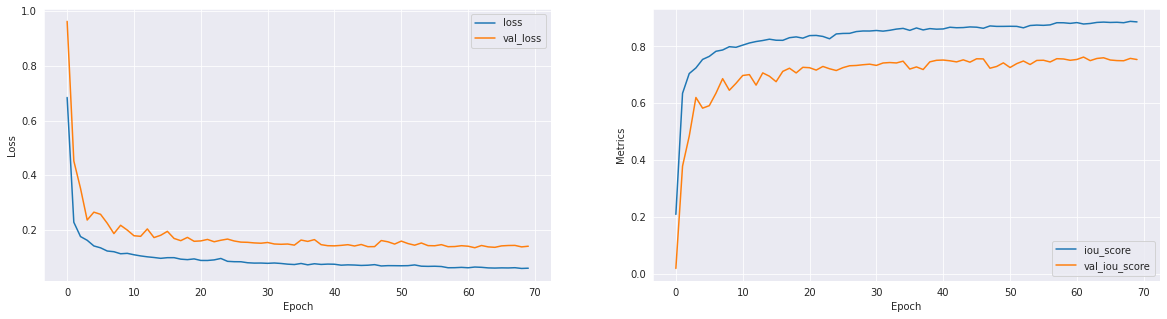



1/1 [==============================] - 1s 632ms/step


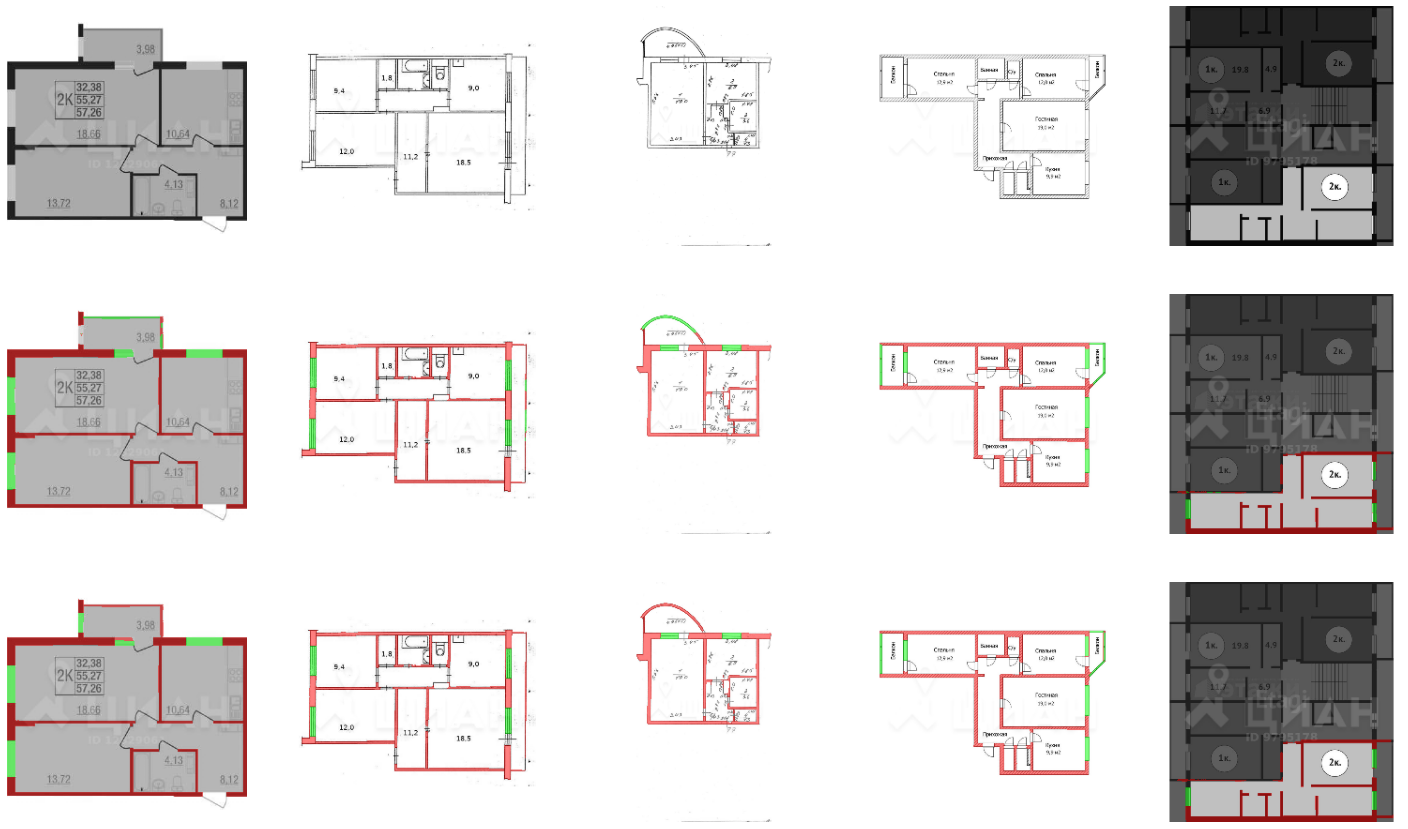


Epoch 70: val_iou_score did not improve from 0.76256

Epoch 70: saving model to /content/drive/MyDrive/Documents/FLOORS/WINDOW/Results/U_Net_1/U_Net_1_last.h5
186/186 [==============================] - 265s 1s/step - loss: 0.0609 - iou_score: 0.8862 - val_loss: 0.1412 - val_iou_score: 0.7539 - lr: 7.0000e-05
Epoch 71/100
186/186 [==============================] - ETA: 0s - loss: 0.0623 - iou_score: 0.8838

loss: 0.0623, best_loss: 0.06
iou_score: 0.8838, best_iou_score: 0.8882
val_loss: 0.1418, best_val_loss: 0.1356
val_iou_score: 0.7529, best_val_iou_score: 0.7626

Epoch 71: val_iou_score did not improve from 0.76256

Epoch 71: saving model to /content/drive/MyDrive/Documents/FLOORS/WINDOW/Results/U_Net_1/U_Net_1_last.h5
186/186 [==============================] - 249s 1s/step - loss: 0.0623 - iou_score: 0.8838 - val_loss: 0.1418 - val_iou_score: 0.7529 - lr: 7.0000e-05
Epoch 72/100
186/186 [==============================] - ETA: 0s - loss: 0.0607 - iou_score: 0.8866

loss: 0.0607, be

In [ ]:
dice_loss = DiceLoss()
iou_score = IOUScore()

model.compile(optimizer = Adam(learning_rate = 1e-4), loss = dice_loss, 
                metrics = iou_score)

checkpoint_callback_best = ModelCheckpoint(monitor = 'val_iou_score', 
                                          mode = 'max',
                                          filepath = os.path.join(PATH_MODEL_WINDOW, MODEL_FILENAME_WINDOW),
                                          save_weights_only = False,
                                          save_best_only = True,
                                          verbose = 1)


checkpoint_callback_last = ModelCheckpoint(filepath = os.path.join(PATH_MODEL_WINDOW, MODEL_FILENAME_WINDOW_LAST),
                                              save_weights_only = False,
                                              save_best_only = False,
                                              verbose = 1)

plateau_callback = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, verbose = 1,
                                     min_lr = 1e-10)                

callbacks = [callback_on_epoch_end_window, checkpoint_callback_best, 
             checkpoint_callback_last, plateau_callback]

history = model.fit(train_generator_window, validation_data = val_generator_window,
                    epochs = 78, verbose = 1, 
                    use_multiprocessing = True,
                    workers = multiprocessing.cpu_count(),
                    callbacks = callbacks, 
                    initial_epoch = 0)

### Сеанс №2


 Epoch:  100
loss: 0.0515, best_loss: 0.051
iou_score: 0.903, best_iou_score: 0.9037
val_loss: 0.1343, best_val_loss: 0.1327
val_iou_score: 0.7648, best_val_iou_score: 0.7672


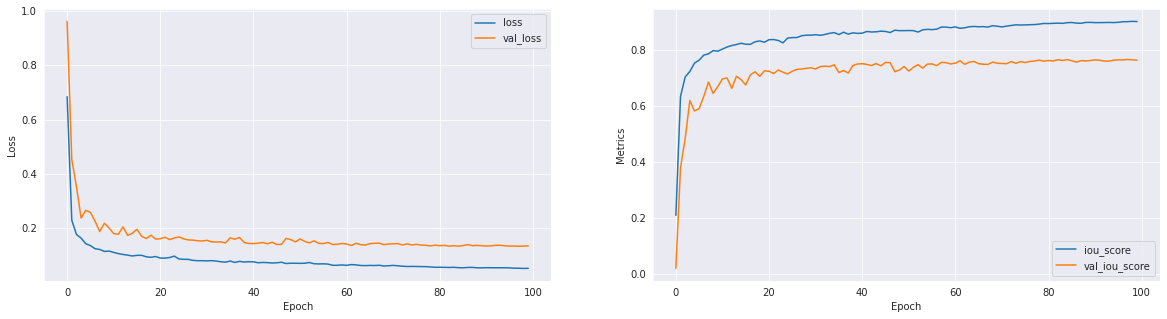



1/1 [==============================] - 1s 596ms/step


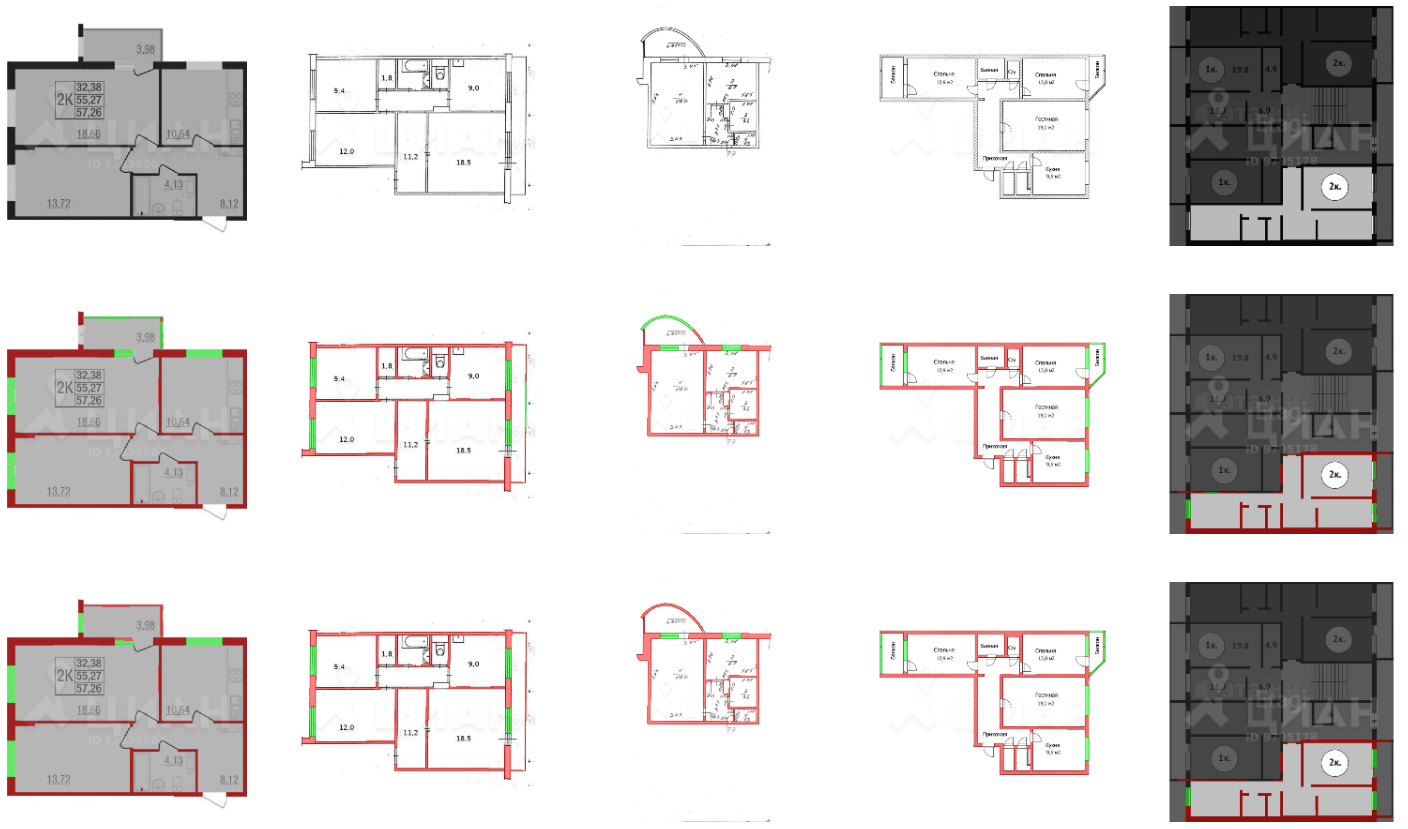


Epoch 100: val_iou_score did not improve from 0.76716

Epoch 100: saving model to /content/drive/MyDrive/Documents/FLOORS/WINDOW/Results/U_Net_1/U_Net_1_last.h5
186/186 [==============================] - 268s 1s/step - loss: 0.0515 - iou_score: 0.9030 - val_loss: 0.1343 - val_iou_score: 0.7648 - lr: 1.2500e-05


In [ ]:
model = load_model(os.path.join(PATH_MODEL_WINDOW, MODEL_FILENAME_WINDOW_LAST), 
                   custom_objects = {'dice_loss':  DiceLoss(),
                                     'iou_score': IOUScore()})

dice_loss = DiceLoss()
iou_score = IOUScore()

model.compile(optimizer = Adam(learning_rate = 0.25e-4), loss = dice_loss, 
                metrics = iou_score)

initial_value_threshold = max(np.load(os.path.join(PATH_MODEL_WINDOW, 'val_iou_score.npy')))

checkpoint_callback_best = ModelCheckpoint(monitor = 'val_iou_score', 
                                          mode = 'max',
                                          filepath = os.path.join(PATH_MODEL_WINDOW, MODEL_FILENAME_WINDOW),
                                          save_weights_only = False,
                                          save_best_only = True,
                                          verbose = 1,
                                          initial_value_threshold = initial_value_threshold)


checkpoint_callback_last = ModelCheckpoint(filepath = os.path.join(PATH_MODEL_WINDOW, MODEL_FILENAME_WINDOW_LAST),
                                              save_weights_only = False,
                                              save_best_only = False,
                                              verbose = 1)

plateau_callback = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, verbose = 1,
                                     min_lr = 1e-10)                

callbacks = [callback_on_epoch_end_window, checkpoint_callback_best, 
             checkpoint_callback_last, plateau_callback]

initial_epoch = len(np.load(os.path.join(PATH_MODEL_WINDOW, 'loss.npy')))

history = model.fit(train_generator_window, validation_data = val_generator_window,
                    epochs = 100, verbose = 1, 
                    use_multiprocessing = True,
                    workers = multiprocessing.cpu_count(),
                    callbacks = callbacks, 
                    initial_epoch = initial_epoch)

# Обнаружение дверей

In [ ]:
files_door = sorted(os.listdir(os.path.join(PATH, DOOR_DIR)))

for i in range(len(files_door)):
  files_door[i] = os.path.join(PATH, DOOR_DIR, files_door[i]) 

In [ ]:
N_TOTAL = len(files_door)
N_TRAIN = N_TOTAL - N_VAL - N_TEST

In [ ]:
model_wall = load_model(os.path.join(PATH_MODEL_WALL, MODEL_FILENAME_WALL), 
                        custom_objects = {'dice_loss':  DiceLoss(),
                                          'iou_score': IOUScore()})

model_window = load_model(os.path.join(PATH_MODEL_WINDOW, MODEL_FILENAME_WINDOW), 
                          custom_objects = {'dice_loss':  DiceLoss(),
                                            'iou_score': IOUScore()})

## Формирование датасета для обнаружения дверей

In [ ]:
for i, filepath in enumerate(files_door):

  with open(filepath) as f:
    object_dict = json.load(f)

  bytearray_ = np.asarray(bytearray(base64.b64decode(object_dict['imageData'])), dtype=np.uint8)
  image = cv2.imdecode(bytearray_, cv2.IMREAD_COLOR)
  image = Image.fromarray(image)
  image = ImageOps.grayscale(image)

  image_size = image.size

  shift = 0
  transitional_size = [0, 0]
  index_min_side = None
  index_max_side = None


  if image_size[0] == image_size[1]:
    new_image = image.resize((SIZE[1], SIZE[0]),  resample = Image.LANCZOS)
    new_image = np.array(new_image)
    

  else:
    index_min_side = np.argmin(image_size)
    index_max_side = np.argmax(image_size)

    transitional_size[index_max_side] = SIZE[0]
    transitional_size[index_min_side] = int(image_size[index_min_side]*(SIZE[0]/image_size[index_max_side]))

    
    transitional_image = image.resize(transitional_size, resample = Image.LANCZOS)

    transitional_image = np.array(transitional_image)

    new_image = 255*np.ones((SIZE))

    shift = int((SIZE[0] - transitional_size[index_min_side])*0.5) 
    if index_min_side == 1:
      new_image[shift:shift+transitional_size[index_min_side], :] = transitional_image
    else:
      new_image[:, shift:shift+transitional_size[index_min_side]] = transitional_image

  image_width = image_size[0]
  image_height = image_size[1]

  text = ''

  new_image_box = new_image.copy()

  for  shape in object_dict['shapes']:
    if shape['label'] == 'door':
      coordinates = shape['points']

      min_height = image_height
      min_width = image_width
      max_height = 0
      max_width = 0

      current_mins = np.min(coordinates, axis = 0)
      current_maxs = np.max(coordinates, axis = 0)

      if current_mins[1] < min_height:
        min_height = current_mins[1]

      if current_mins[0] < min_width:
        min_width = current_mins[0]

      if current_maxs[1] > max_height:
        max_height = current_maxs[1]

      if current_maxs[0] > max_width:
        max_width = current_maxs[0]

      WIDTH = max_width + 1 - min_width
      HEIGHT = max_height + 1 - min_height
      X_CENTER = (min_width+max_width)*0.5
      Y_CENTER = (min_height+max_height)*0.5

      WIDTH_NORM = WIDTH/image_width
      HEIGHT_NORM = HEIGHT/image_height
      X_CENTER_NORM = X_CENTER/image_width
      Y_CENTER_NORM = Y_CENTER/image_height

      if shift:
        if index_min_side == 1:
          new_image[shift:shift+transitional_size[index_min_side], :] = transitional_image
          
          HEIGHT = HEIGHT_NORM*transitional_size[index_min_side]
          HEIGHT_NORM = HEIGHT/SIZE[0]

          Y_CENTER = Y_CENTER_NORM*transitional_size[index_min_side]
          Y_CENTER = Y_CENTER + shift
          Y_CENTER_NORM = Y_CENTER/SIZE[0]

        else:
          new_image[:, shift:shift+transitional_size[index_min_side]] = transitional_image
        
          WIDTH = WIDTH_NORM*transitional_size[index_min_side]
          WIDTH_NORM = WIDTH/SIZE[0]

          X_CENTER = X_CENTER_NORM*transitional_size[index_min_side]
          X_CENTER = X_CENTER + shift
          X_CENTER_NORM = X_CENTER/SIZE[0]


      text += f'0 {X_CENTER_NORM} {Y_CENTER_NORM} {WIDTH_NORM} {HEIGHT_NORM}\n'

      
  new_image_for_predict = preprocess_input(new_image)[np.newaxis,...,np.newaxis]

  mask_wall = model_wall.predict(new_image_for_predict, verbose = 0)
  mask_wall[mask_wall < 0.5] = 0
  mask_wall[mask_wall >= 0.5] = 1

  mask_window = model_window.predict(np.concatenate([new_image_for_predict, mask_wall], axis = -1), verbose = 0)

  mask_window[mask_window < 0.5] = 0
  mask_window[mask_window >= 0.5] = 1

  new_image = -new_image + 255 # инвертируем цвета


  new_image = new_image[...,np.newaxis]
  mask_wall = 255*mask_wall[0]
  mask_window = 255*mask_window[0]
  image_for_object_detection = np.concatenate([new_image, mask_wall, mask_window], axis = -1)

  image_for_object_detection = Image.fromarray(np.uint8(image_for_object_detection))

  path_save_image = None
  path_save_label = None

  file_name_image = object_dict['imagePath'] 
  file_name_label = file_name_image.replace('png', 'txt')
  file_name_label = file_name_label.replace('jpg', 'txt')

  if i < N_TRAIN:
    path_save_image = os.path.join(PATH, DOOR_PROCESSED_DIR, IMAGES_DIR, TRAIN_DIR, file_name_image)
    path_save_label = os.path.join(PATH, DOOR_PROCESSED_DIR, LABELS_DIR, TRAIN_DIR, file_name_label)

  elif i < N_TRAIN+N_VAL:
    path_save_image = os.path.join(PATH, DOOR_PROCESSED_DIR, IMAGES_DIR, VAL_DIR, file_name_image)
    path_save_label = os.path.join(PATH, DOOR_PROCESSED_DIR, LABELS_DIR, VAL_DIR, file_name_label)

  else:
    path_save_image = os.path.join(PATH, DOOR_PROCESSED_DIR, IMAGES_DIR, TEST_DIR, file_name_image)
    path_save_label = os.path.join(PATH, DOOR_PROCESSED_DIR, LABELS_DIR, TEST_DIR, file_name_label)

  image_for_object_detection.save(path_save_image)
  
  if text != '':
    with open(path_save_label, "w") as f:
      f.write(text)


## Обучение

In [ ]:
%cd drive/MyDrive/Documents/FLOORS/DOORS
!git clone https://github.com/ultralytics/yolov5  
clear_output()

In [ ]:
%cd yolov5

In [ ]:
!pip install -r requirements.txt  
clear_output()

In [ ]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.12.1+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
yaml_file = f"train: /content/drive/MyDrive/Documents/FLOORS/train_dataset_train/object_detection_1/images/train\nval: /content/drive/MyDrive/Documents/FLOORS/train_dataset_train/object_detection_1/images/val\n\nnc: 1\nnames: ['Door']"

with open("data.yaml", "w") as f:
  f.write(yaml_file)

In [ ]:
%cat data.yaml

train: /content/drive/MyDrive/Documents/FLOORS/train_dataset_train/object_detection_1/images/train
val: /content/drive/MyDrive/Documents/FLOORS/train_dataset_train/object_detection_1/images/val

nc: 1
names: ['Door']

In [ ]:
%%time
!python train.py --img 256 --batch 16 --epochs 100 --data 'data.yaml' --cfg models/yolov5x.yaml --weights '' --name yolov5x_results --cache

train: weights=, cfg=models/yolov5x.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5x_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-5-gbfa1f23 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s

# Распознавание на тестовом датасете

In [ ]:
%cd /content/drive/MyDrive/Documents/FLOORS/DOORS/yolov5
model_door = torch.hub.load('.', 'custom', path = PATH_YOLO_MODEL, source='local')
%cd //content
clear_output()

In [ ]:
files_test = sorted(os.listdir(PATH_TEST))

In [ ]:
for filename in files_test:
  
  image = Image.open(os.path.join(PATH_TEST, filename))

  image = ImageOps.grayscale(image)

  image_size = image.size

  shift = 0
  transitional_size = [0, 0]
  index_min_side = None
  index_max_side = None


  if image_size[0] == image_size[1]:
    new_image = image.resize((SIZE[1], SIZE[0]),  resample = Image.LANCZOS)
    new_image = np.array(new_image)
    

  else:
    index_min_side = np.argmin(image_size)
    index_max_side = np.argmax(image_size)

    transitional_size[index_max_side] = SIZE[0]
    transitional_size[index_min_side] = int(image_size[index_min_side]*(SIZE[0]/image_size[index_max_side]))

    
    transitional_image = image.resize(transitional_size, resample = Image.LANCZOS)

    transitional_image = np.array(transitional_image)

    new_image = 255*np.ones((SIZE))

    shift = int((SIZE[0] - transitional_size[index_min_side])*0.5) 
    if index_min_side == 1:
      new_image[shift:shift+transitional_size[index_min_side], :] = transitional_image
    else:
      new_image[:, shift:shift+transitional_size[index_min_side]] = transitional_image

  new_image = Image.fromarray(new_image)

  new_image_horizontal_flip = new_image.transpose(Image.FLIP_LEFT_RIGHT)
  new_image_vertical_flip = new_image.transpose(Image.FLIP_TOP_BOTTOM)
  new_image_rotate_90 = new_image.rotate(90)
  new_image_rotate_180 = new_image.rotate(180)
  new_image_rotate_270 = new_image.rotate(270)

  new_image_for_predict = np.concatenate([np.array(new_image)[np.newaxis, ...], np.array(new_image_horizontal_flip)[np.newaxis, ...], 
                                          np.array(new_image_vertical_flip)[np.newaxis, ...], np.array(new_image_rotate_90)[np.newaxis, ...], 
                                          np.array(new_image_rotate_180)[np.newaxis, ...], np.array(new_image_rotate_270)[np.newaxis, ...]], axis = 0)
  
  new_image_for_predict = preprocess_input(new_image_for_predict)[..., np.newaxis]
  mask_wall = model_wall.predict(new_image_for_predict, verbose = 0)
  

  mask_wall_horizontal_flip_restore = Image.fromarray(np.squeeze(mask_wall[1])).transpose(Image.FLIP_LEFT_RIGHT)
  mask_wall_vertical_flip_restore = Image.fromarray(np.squeeze(mask_wall[2])).transpose(Image.FLIP_TOP_BOTTOM)
  mask_wall_rotate_90_restore = Image.fromarray(np.squeeze(mask_wall[3])).rotate(270)
  mask_wall_rotate_180_restore = Image.fromarray(np.squeeze(mask_wall[4])).rotate(180)
  mask_wall_rotate_270_restore = Image.fromarray(np.squeeze(mask_wall[5])).rotate(90)

  mask_wall_final = np.concatenate([np.squeeze(mask_wall[0])[np.newaxis, ...], np.array(mask_wall_horizontal_flip_restore)[np.newaxis, ...], 
                                    np.array(mask_wall_vertical_flip_restore)[np.newaxis, ...], np.array(mask_wall_rotate_90_restore)[np.newaxis, ...], 
                                    np.array(mask_wall_rotate_180_restore)[np.newaxis, ...], np.array(mask_wall_rotate_270_restore)[np.newaxis, ...]], axis = 0)
  
  mask_wall_final = np.mean(mask_wall_final, axis = 0)

  mask_wall_final[mask_wall_final < 0.5] = 0
  mask_wall_final[mask_wall_final >= 0.5] = 1


  mask_wall[mask_wall < 0.5] = 0
  mask_wall[mask_wall >= 0.5] = 1

  mask_window = model_window.predict(np.concatenate([new_image_for_predict, mask_wall], axis = -1), verbose = 0)

  mask_window_horizontal_flip_restore = Image.fromarray(np.squeeze(mask_window[1])).transpose(Image.FLIP_LEFT_RIGHT)
  mask_window_vertical_flip_restore = Image.fromarray(np.squeeze(mask_window[2])).transpose(Image.FLIP_TOP_BOTTOM)
  mask_window_rotate_90_restore = Image.fromarray(np.squeeze(mask_window[3])).rotate(270)
  mask_window_rotate_180_restore = Image.fromarray(np.squeeze(mask_window[4])).rotate(180)
  mask_window_rotate_270_restore = Image.fromarray(np.squeeze(mask_window[5])).rotate(90)

  mask_window_final = np.concatenate([np.squeeze(mask_window[0])[np.newaxis, ...], np.array(mask_window_horizontal_flip_restore)[np.newaxis, ...], 
                                    np.array(mask_window_vertical_flip_restore)[np.newaxis, ...], np.array(mask_window_rotate_90_restore)[np.newaxis, ...], 
                                    np.array(mask_window_rotate_180_restore)[np.newaxis, ...], np.array(mask_window_rotate_270_restore)[np.newaxis, ...]], axis = 0)
  
  mask_window_final = np.mean(mask_window_final, axis = 0)

  mask_window_final[mask_window_final < 0.5] = 0
  mask_window_final[mask_window_final >= 0.5] = 1

  new_image = np.array(new_image)

  new_image = -new_image + 255 # инвертируем цвета


  mask_wall = 255*mask_wall_final
  mask_window = 255*mask_window_final
  image_for_object_detection = np.concatenate([new_image[...,np.newaxis], mask_wall[...,np.newaxis], mask_window[...,np.newaxis]], axis = -1)

  image_for_object_detection = Image.fromarray(np.uint8(image_for_object_detection))

  image_for_object_detection.save(filename)

  object_detection_results = model_door(filename)
  table_coordinates = object_detection_results.pandas().xyxy[0]

  mask_door = np.zeros((SIZE))

  for i in range(len(table_coordinates)):

    if table_coordinates.iloc[i]['confidence'] < 0.5:
      continue

    xmin = round(table_coordinates.iloc[i]['xmin'])
    xmax = round(table_coordinates.iloc[i]['xmax'])
    ymin = round(table_coordinates.iloc[i]['ymin'])
    ymax = round(table_coordinates.iloc[i]['ymax'])

    mask_door[ymin:ymax+1, xmin:xmax+1] = 255
    
  if image_size[0] != image_size[1]:

    # Вырезаем
    if index_min_side == 1:
      mask_wall = mask_wall[shift:shift+transitional_size[index_min_side], :]
      mask_window =  mask_window[shift:shift+transitional_size[index_min_side], :]
      mask_door =  mask_door[shift:shift+transitional_size[index_min_side], :]
    else:
      mask_wall = mask_wall[:, shift:shift+transitional_size[index_min_side]]
      mask_window = mask_window[:, shift:shift+transitional_size[index_min_side]]
      mask_door = mask_door[:, shift:shift+transitional_size[index_min_side]]

  mask_wall = Image.fromarray(mask_wall)
  mask_window = Image.fromarray(mask_window)
  mask_door = Image.fromarray(mask_door)

  mask_wall = mask_wall.resize(image_size, resample = Image.BICUBIC)
  mask_window = mask_window.resize(image_size, resample = Image.BICUBIC)
  mask_door = mask_door.resize(image_size, resample = Image.BICUBIC)

  mask_wall = np.array(mask_wall)
  mask_window = np.array(mask_window)
  mask_door = np.array(mask_door)

  mask_wall[mask_wall < 128] = 0
  mask_wall[mask_wall >= 128] = 1

  mask_window[mask_window < 128] = 0
  mask_window[mask_window >= 128] = 1

  mask_door[mask_door < 128] = 0
  mask_door[mask_door >= 128] = 1

  mask_wall = mask_wall.astype(bool)
  mask_window = mask_window.astype(bool)
  mask_door = mask_door.astype(bool)

  total_mask = np.zeros(image_size[::-1], dtype = np.uint8)
  total_mask[mask_wall] = 1
  total_mask[mask_window] = 2
  total_mask[mask_door] = 3

  total_mask = Image.fromarray(total_mask)
  
  total_mask.save(os.path.join(PATH_SUBMIT, filename))


# Примеры распознавания

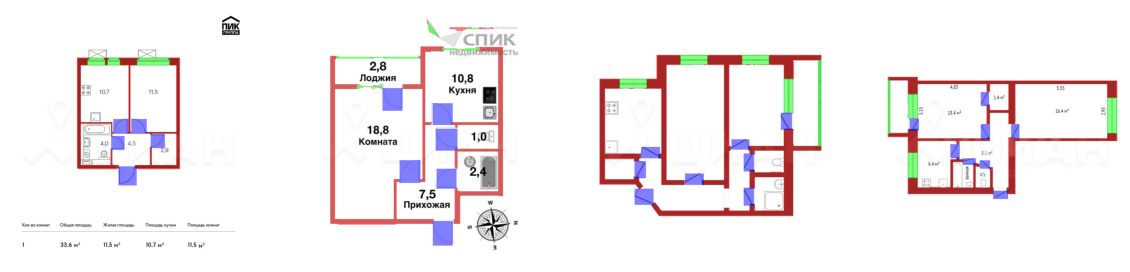

In [ ]:
n_examples = 4
examples = np.random.choice(files_test, n_examples)

plt.figure(figsize = (20, 5))

for i, filename in enumerate(examples):
  image = Image.open(os.path.join(PATH_TEST, filename))
  image = np.array(image)

  mask = Image.open(os.path.join(PATH_SUBMIT, filename))
  mask = np.array(mask)

  if image.ndim == 2:
    image = np.repeat(image, 3).reshape(image.shape[0], image.shape[1], 3)

  masked_image = np.where((mask==1)[...,None], COLOR_WALL, image)
  masked_image = np.where((mask==2)[...,None], COLOR_WINDOW, masked_image)
  masked_image = np.where((mask==3)[...,None], COLOR_DOOR, masked_image)

  masked_image = cv2.addWeighted(image, COLOR_RATIO, masked_image, 1 - COLOR_RATIO, 0)
  
  plt.subplot(1, 4, i+1)
  plt.imshow(masked_image)
  plt.axis('off')